In [29]:
import pandas as pd
import numpy as np
import fastsparsegams
df = pd.read_csv('./pharyngitis.csv')
df = df.drop('number', axis=1)

In [30]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=20, stratify=df['radt'])

In [31]:
train_df['swollenadp'].sort_values().unique()

array([ 0.,  1.,  2.,  3., nan])

In [32]:
def binarize_according_to_train(train_df, test_df):
    n_train, d_train = train_df.shape
    n_test, d_test = test_df.shape
    train_binned, train_augmented_binned, test_binned, test_augmented_binned = {}, {}, {}, {}
    for c in train_df.columns:
        if c == 'radt':
            continue
        for v in train_df[c].sort_values().unique():
            if np.isnan(v):
                new_col_name = f'{c} missing'

                new_row_train = np.zeros(n_train)
                new_row_train[train_df[c].isna()] = 1
                train_binned[new_col_name] = new_row_train
                train_augmented_binned[new_col_name] = new_row_train
                
                new_row_test = np.zeros(n_test)
                new_row_test[test_df[c].isna()] = 1
                test_binned[new_col_name] = new_row_test
                test_augmented_binned[new_col_name] = new_row_test
            else:
                new_col_name = f'{c} <= {v}'

                new_row_train = np.zeros(n_train)
                new_row_train[train_df[c] <= v] = 1
                train_binned[new_col_name] = new_row_train
                train_augmented_binned[new_col_name] = new_row_train
                
                new_row_test = np.zeros(n_test)
                new_row_test[test_df[c] <= v] = 1
                test_binned[new_col_name] = new_row_test
                test_augmented_binned[new_col_name] = new_row_test
    
    for c_outer in train_df.columns:
        if c_outer == 'radt':
            continue
        for c_inner in train_df.columns:
            for v in train_df[c_inner].sort_values().unique():
                if np.isnan(v) or c_inner == 'radt':
                    continue
                else:
                    new_col_name = f'{c_outer}_missing & {c_inner} <= {v}'

                    new_row_train = np.zeros(n_train)
                    new_row_train[(train_df[c_outer].isna()) & (train_df[c_inner] <= v)] = 1
                    train_augmented_binned[new_col_name] = new_row_train

                    new_row_test = np.zeros(n_test)
                    new_row_test[(test_df[c_outer].isna()) & (test_df[c_inner] <= v)] = 1
                    test_augmented_binned[new_col_name] = new_row_test
    train_binned['radt'] = train_df['radt']
    test_binned['radt'] = test_df['radt']
    train_augmented_binned['radt'] = train_df['radt']
    test_augmented_binned['radt'] = test_df['radt']
    return pd.DataFrame(train_binned), pd.DataFrame(train_augmented_binned), \
         pd.DataFrame(test_binned), pd.DataFrame(test_augmented_binned)

In [33]:
train_binned, train_binned_augmented, test_binned, test_binned_augmented = binarize_according_to_train(train_df, test_df)

X_indicator_train = train_binned[train_binned.columns[:-1]].values
y_train = train_binned['radt'].values

X_indicator_test = test_binned[test_binned.columns[:-1]].values
y_test = test_binned['radt'].values

X_aug_train = train_binned_augmented[train_binned_augmented.columns[:-1]].values

X_aug_test = test_binned_augmented[test_binned_augmented.columns[:-1]].values

In [34]:
X_indicator_test.shape

(136, 186)

In [35]:
model_indicator = fastsparsegams.fit(
    X_indicator_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI"
)

In [36]:
model_aug = fastsparsegams.fit(
    X_aug_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI"
)

In [37]:
#recover coefficients and train/test probabilities
def eval_model(model, X_train, X_test): 
    coeffs = np.zeros((len(model.lambda_0[0]), X_train.shape[1]))
    train_probs = np.zeros((len(model.lambda_0[0]), X_train.shape[0]))
    test_probs = np.zeros((len(model.lambda_0[0]), X_test.shape[0]))

    for i, lamby in enumerate(model.lambda_0[0]): 
        train_probs[i] = model.predict(X_train.astype(float),lambda_0=lamby).reshape(-1)
        test_probs[i] = model.predict(X_test.astype(float),lambda_0=lamby).reshape(-1)

        coeffs[i] = (model.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    return train_probs, test_probs, coeffs

In [38]:
train_probs_aug, test_probs_aug, coeff_aug = eval_model(model_aug, X_aug_train, X_aug_test)
trainacc_aug = ((train_probs_aug > 0.5) == y_train).mean(axis = 1)
testacc_aug = ((test_probs_aug > 0.5) == y_test).mean(axis = 1)
num_terms_aug = (coeff_aug != 0).sum(axis=1)

In [40]:
train_probs_indicator, test_probs_indicator, coeff_indicator = eval_model(model_indicator, X_indicator_train, X_indicator_test)
trainacc_indicator = ((train_probs_indicator > 0.5) == y_train).mean(axis=1)
testacc_indicator = ((test_probs_indicator > 0.5) == y_test).mean(axis=1)
num_terms_indicator = (coeff_indicator != 0).sum(axis=1)

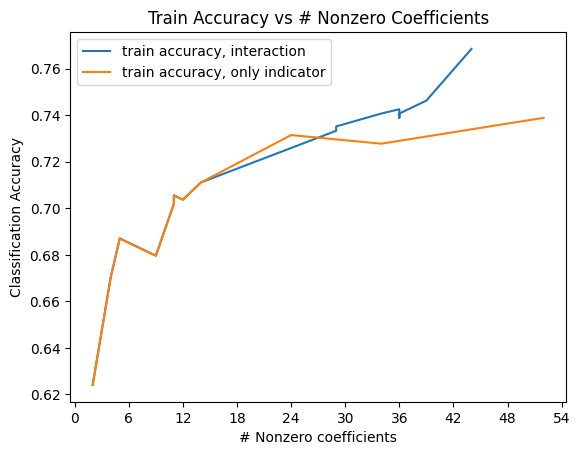

In [41]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Train Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
plt.plot(num_terms_aug[num_terms_aug > 0], trainacc_aug[num_terms_aug > 0], label='train accuracy, interaction')
plt.plot(num_terms_indicator[num_terms_indicator > 0], trainacc_indicator[num_terms_indicator > 0], label='train accuracy, only indicator')
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

plt.legend()

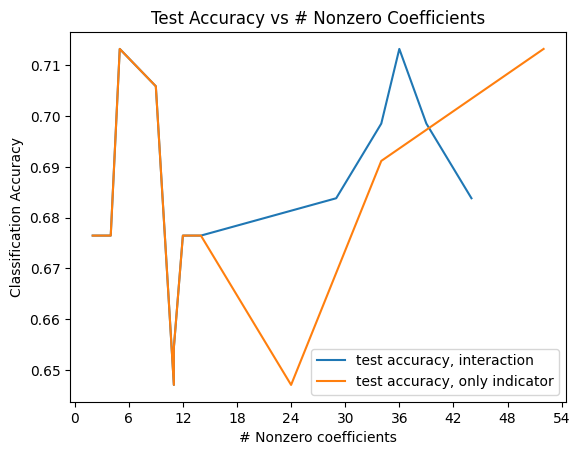

In [42]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Test Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
plt.plot(num_terms_aug[num_terms_aug > 0], testacc_aug[num_terms_aug > 0], label='test accuracy, interaction')
plt.plot(num_terms_indicator[num_terms_indicator > 0], testacc_indicator[num_terms_indicator > 0], label='test accuracy, only indicator')
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

plt.legend()

In [58]:
names = train_binned_augmented.columns[:-1][abs(model_aug.coeff(lambda_0=0.2).toarray().flatten()[1:]) > 0]
coef_dict = {}
for i, v in enumerate(model_aug.coeff(lambda_0=0.2).toarray().flatten()[1:][abs(model_aug.coeff(lambda_0=0.2).toarray().flatten()[1:]) > 0]):
    coef_dict[names[i]] = v
print(names)

Index(['age_y <= 3.3', 'age_y <= 3.6', 'age_y <= 4.2', 'age_y <= 4.6',
       'age_y <= 6.1', 'age_y <= 6.8', 'age_y <= 7.1', 'age_y <= 9.0',
       'age_y <= 9.5', 'age_y <= 12.0', 'age_y <= 12.9', 'swollenadp <= 0.0',
       'tender <= 0.0', 'tonsillarswelling <= 0.0', 'temperature <= 37.9',
       'temperature <= 38.0', 'temperature <= 38.2', 'temperature <= 38.5',
       'temperature <= 38.6', 'temperature <= 38.7', 'temperature <= 39.1',
       'sudden <= 0.0', 'cough <= 0.0', 'petechiae <= 0.0', 'abdopain <= 0.0',
       'diarrhea <= 0.0', 'nauseavomit <= 0.0', 'scarlet <= 0.0',
       'pain_missing & age_y <= 4.3', 'tender_missing & temperature <= 39.4',
       'tonsillarswelling_missing & scarlet <= 0.0',
       'sudden_missing & cough <= 0.0', 'petechiae_missing & exudate <= 0.0',
       'petechiae_missing & diarrhea <= 0.0',
       'diarrhea_missing & age_y <= 8.1',
       'scarlet_missing & swollenadp <= 2.0'],
      dtype='object')


In [56]:
names = train_binned.columns[:-1][abs(model_indicator.coeff(lambda_0=0.2).toarray().flatten()[1:]) > 0]
coef_dict = {}
for i, v in enumerate(model_indicator.coeff(lambda_0=0.2).toarray().flatten()[1:][abs(model_indicator.coeff(lambda_0=0.2).toarray().flatten()[1:]) > 0]):
    coef_dict[names[i]] = v
print(len(coef_dict))
print(names)

34
Index(['age_y <= 3.3', 'age_y <= 3.6', 'age_y <= 4.2', 'age_y <= 4.6',
       'age_y <= 6.1', 'age_y <= 6.8', 'age_y <= 7.1', 'age_y <= 7.3',
       'age_y <= 9.0', 'age_y <= 9.5', 'age_y <= 10.1', 'age_y <= 12.0',
       'age_y <= 12.9', 'swollenadp <= 0.0', 'swollenadp <= 1.0',
       'tender <= 0.0', 'tonsillarswelling <= 0.0', 'tonsillarswelling <= 1.0',
       'exudate <= 0.0', 'temperature <= 38.6', 'temperature <= 38.7',
       'temperature <= 38.9', 'temperature <= 39.1', 'temperature <= 39.9',
       'sudden <= 0.0', 'cough <= 0.0', 'cough <= 1.0', 'petechiae <= 0.0',
       'petechiae <= 1.0', 'abdopain <= 0.0', 'diarrhea <= 0.0',
       'diarrhea <= 1.0', 'nauseavomit <= 0.0', 'scarlet <= 0.0'],
      dtype='object')


In [46]:
train_binned.columns[:-1][abs(model_indicator.coeff(lambda_0=0.06).toarray().flatten()[1:]) > 0]

Index(['age_y <= 3.3', 'age_y <= 3.6', 'age_y <= 3.9', 'age_y <= 4.2',
       'age_y <= 4.4', 'age_y <= 4.6', 'age_y <= 4.7', 'age_y <= 5.2',
       'age_y <= 5.5', 'age_y <= 5.6', 'age_y <= 6.1', 'age_y <= 6.4',
       'age_y <= 6.5', 'age_y <= 6.8', 'age_y <= 7.1', 'age_y <= 7.3',
       'age_y <= 9.0', 'age_y <= 9.5', 'age_y <= 10.1', 'age_y <= 11.3',
       'age_y <= 12.0', 'age_y <= 12.9', 'pain <= 0.0', 'swollenadp <= 0.0',
       'swollenadp <= 1.0', 'tender <= 0.0', 'tender missing',
       'tonsillarswelling <= 0.0', 'tonsillarswelling <= 1.0',
       'exudate <= 0.0', 'exudate <= 1.0', 'temperature <= 37.9',
       'temperature <= 38.0', 'temperature <= 38.3', 'temperature <= 38.6',
       'temperature <= 38.7', 'temperature <= 38.9', 'temperature <= 39.1',
       'temperature <= 39.5', 'temperature <= 39.9', 'sudden <= 0.0',
       'cough <= 0.0', 'cough <= 1.0', 'rhinorrhea <= 0.0', 'headache <= 0.0',
       'petechiae <= 0.0', 'petechiae <= 1.0', 'abdopain <= 0.0',
       

In [19]:

X_aug_train.shape

(540, 14195)